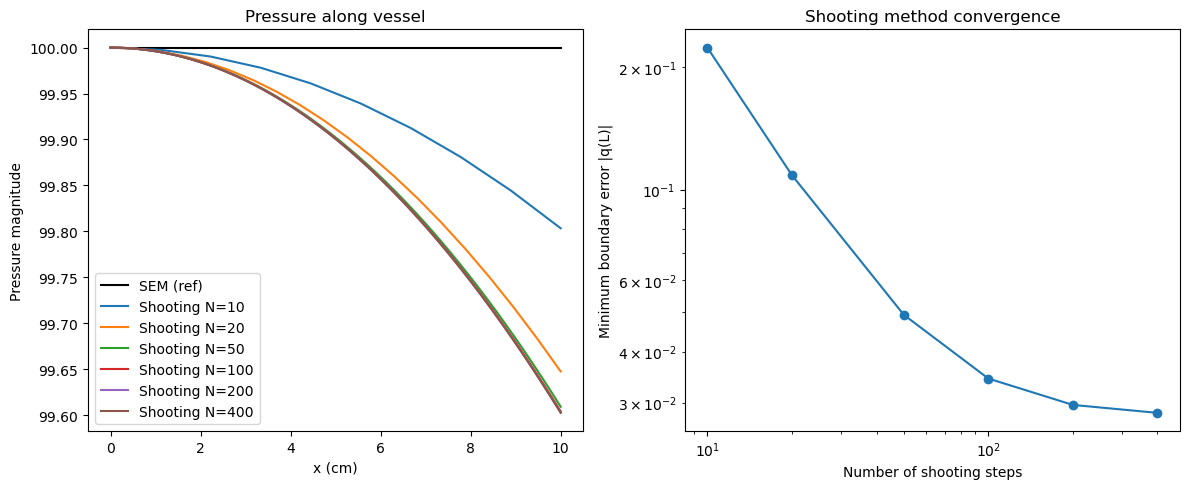

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters (simplified)
L = 10.0  # vessel length (cm)
N_ref = 1000  # reference points for SEM (treated as exact)
omega = 2 * np.pi * 1.0  # angular frequency (rad/s)
rho = 1.055  # blood density (g/cm^3)
E = 1.5e7  # Young's modulus (g/cm/s^2)
h = 0.06  # wall thickness (cm)
R0 = 0.86  # radius (cm)
A0 = np.pi * R0**2  # cross-sectional area (cm^2)
c0 = np.sqrt(E * h / (2 * rho * R0))  # wave speed (cm/s)

# System matrix A for linearized frequency domain ODE: d/dx [p; q] = A [p; q]
# Simplified from wave propagation theory
def system_matrix(omega, c0, A0, rho):
    # Wave number k = omega / c0
    k = omega / c0
    A = np.array([[0, -1j * omega * rho / A0],
                  [-1j * omega * A0 / rho / c0**2, 0]])
    return A

# SEM solution (reference) - analytical solution of wave propagation
def sem_solution(x, omega, c0, A0, rho, p_in):
    k = omega / c0
    # Forward and backward waves (assume no reflection for simplicity)
    p = p_in * np.exp(-1j * k * x)
    q = (p_in / (rho * c0)) * np.exp(-1j * k * x)
    return p, q

# Shooting method to solve BVP: p(0) = p_in, q(L) unknown, solve for q(0) to satisfy boundary at x=L
def shooting_method(omega, c0, A0, rho, p_in, L, N_steps):
    A = system_matrix(omega, c0, A0, rho)

    def ode(x, y):
        return A @ y

    # Boundary conditions:
    # At x=0: p = p_in (given), q unknown (shooting parameter)
    # At x=L: q = q_out (assumed zero for simplicity)

    # Shooting parameter: initial q(0)
    q0_guess = 0.0

    def shoot(q0):
        y0 = np.array([p_in, q0], dtype=complex)
        sol = solve_ivp(ode, [0, L], y0, t_eval=[L])
        pL, qL = sol.y[:, -1]
        # Boundary condition at x=L: q(L) = 0 (for example)
        return np.abs(qL)  # want qL close to zero

    # Simple shooting by scanning q0 values
    q0_values = np.linspace(-2, 2, N_steps)
    errors = []
    q0_best = q0_values[0]
    min_error = np.inf
    for q0 in q0_values:
        err = shoot(q0)
        errors.append(err)
        if err < min_error:
            min_error = err
            q0_best = q0

    # Solve with best q0
    y0 = np.array([p_in, q0_best], dtype=complex)
    x_vals = np.linspace(0, L, N_steps)
    sol = solve_ivp(ode, [0, L], y0, t_eval=x_vals)
    p_sol = sol.y[0]
    q_sol = sol.y[1]

    return x_vals, p_sol, q_sol, q0_values, errors

# Main comparison and plotting
def main():
    p_in = 100.0  # inlet pressure (arbitrary units)
    N_steps_list = [10, 20, 50, 100, 200, 400]

    # SEM reference solution
    x_ref = np.linspace(0, L, N_ref)
    p_ref, q_ref = sem_solution(x_ref, omega, c0, A0, rho, p_in)

    plt.figure(figsize=(12, 5))

    # Plot pressure magnitude comparison for different shooting steps
    plt.subplot(1, 2, 1)
    plt.plot(x_ref, np.abs(p_ref), 'k-', label='SEM (ref)')
    for N_steps in N_steps_list:
        x_shoot, p_shoot, q_shoot, q0_vals, errors = shooting_method(omega, c0, A0, rho, p_in, L, N_steps)
        plt.plot(x_shoot, np.abs(p_shoot), label=f'Shooting N={N_steps}')
    plt.xlabel('x (cm)')
    plt.ylabel('Pressure magnitude')
    plt.title('Pressure along vessel')
    plt.legend()

    # Plot convergence of shooting method error at x=L
    plt.subplot(1, 2, 2)
    errors_final = []
    for N_steps in N_steps_list:
        _, _, _, _, errors = shooting_method(omega, c0, A0, rho, p_in, L, N_steps)
        errors_final.append(min(errors))
    plt.loglog(N_steps_list, errors_final, 'o-')
    plt.xlabel('Number of shooting steps')
    plt.ylabel('Minimum boundary error |q(L)|')
    plt.title('Shooting method convergence')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

/opt/anaconda3/lib/python3.12/site-packages/scipy/integrate/_ivp/base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


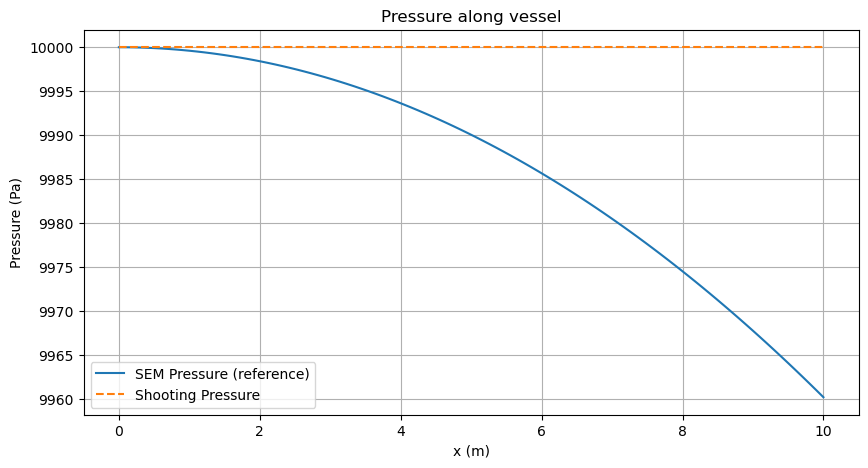

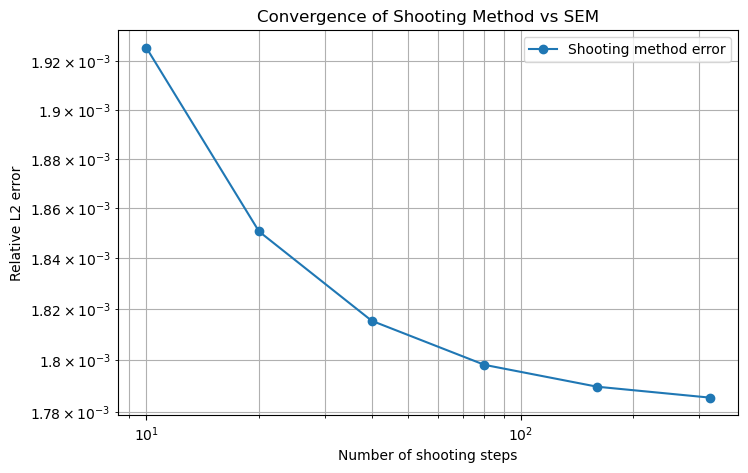

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters (simplified)
L = 10.0  # vessel length (cm)
N_ref = 1000  # reference points for SEM (treated as exact)
omega = 2 * np.pi * 1.0  # angular frequency (rad/s)
rho = 1.055  # blood density (g/cm^3)
E = 1.5e7  # Young's modulus (g/cm/s^2)
h = 0.06  # wall thickness (cm)
R0 = 0.86  # radius (cm)
A0 = np.pi * R0**2  # cross-sectional area (cm^2)
c0 = np.sqrt(E * h / (2 * rho * R0))  # wave speed (cm/s)

# System matrix A for linearized frequency domain ODE: d/dx [p; q] = A [p; q]
# Simplified from wave propagation theory
def system_matrix(omega, c0, A0, rho):
    # Wave number k = omega / c0
    k = omega / c0
    A = np.array([[0, -1j * omega * rho / A0],
                  [-1j * omega * A0 / rho / c0**2, 0]])
    return A

i = 1j
A_mat = np.array([[0, -i * omega * rho / A0],
                  [-i * omega * A0 / (rho * c0**2), 0]])

# SEM solution (reference) - analytical solution of wave propagation
def sem_solution(x):
    # Assume forward traveling wave only, no reflection
    k = omega / c0  # wave number
    p0 = 10000  # reference pressure amplitude (Pa)
    p = p0 * np.exp(-i * k * x)
    q = p / (rho * c0)  # from linearized relations
    return p, q

# Shooting method to solve BVP: p(0) = p_in, q(L) unknown, solve for q(0) to satisfy boundary at x=L
from scipy.optimize import root_scalar
def odes(x, y):
    # y = [p, q]
    dydx = A_mat @ y
    return [dydx[0], dydx[1]]
def shooting_residual(q0_guess):
    # Initial condition: p(0) = p0 (from SEM), q(0) = q0_guess (unknown)
    p0 = 10000
    y0 = [p0, q0_guess]
    sol = solve_ivp(odes, [0, L], y0, t_eval=[L])
    qL = sol.y[1, -1]
    # Boundary condition at x=L: q(L) = 0 (no flow at outlet)
    return np.real(qL)  # root find on real part
def shooting_method():
    # Find q(0) such that q(L) = 0
    res = root_scalar(shooting_residual, bracket=[-1, 1], method='bisect', xtol=1e-6)
    q0_opt = res.root
    p0 = 10000
    y0 = [p0, q0_opt]
    x_vals = np.linspace(0, L, 100)
    sol = solve_ivp(odes, [0, L], y0, t_eval=x_vals)
    return x_vals, sol.y[0], sol.y[1]

# --- Convergence study for shooting method ---
def shooting_convergence(steps_list):
    errors = []
    x_ref = np.linspace(0, L, 1000)
    p_ref, _ = sem_solution(x_ref)
    p_ref = np.real(p_ref)

    for n in steps_list:
        x_vals = np.linspace(0, L, n)
        # Solve shooting with interpolation at these points
        p0 = 10000
        # Find q0 for this discretization (use root_scalar with tighter bracket)
        res = root_scalar(shooting_residual, bracket=[-1, 1], method='bisect', xtol=1e-8)
        q0_opt = res.root
        y0 = [p0, q0_opt]
        sol = solve_ivp(odes, [0, L], y0, t_eval=x_vals)
        p_num = np.real(sol.y[0])
        # Interpolate SEM solution to x_vals
        p_sem_interp = np.interp(x_vals, x_ref, p_ref)
        error = np.linalg.norm(p_num - p_sem_interp) / np.linalg.norm(p_sem_interp)
        errors.append(error)
    return errors

# --- Plotting ---
def plot_results():
    x = np.linspace(0, L, 100)
    p_sem, q_sem = sem_solution(x)
    p_sem = np.real(p_sem)
    q_sem = np.real(q_sem)

    x_shoot, p_shoot, q_shoot = shooting_method()
    p_shoot = np.real(p_shoot)
    q_shoot = np.real(q_shoot)

    plt.figure(figsize=(10, 5))
    plt.plot(x, p_sem, label='SEM Pressure (reference)')
    plt.plot(x_shoot, p_shoot, '--', label='Shooting Pressure')
    plt.xlabel('x (m)')
    plt.ylabel('Pressure (Pa)')
    plt.title('Pressure along vessel')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Convergence plot
    steps_list = [10, 20, 40, 80, 160, 320]
    errors = shooting_convergence(steps_list)
    plt.figure(figsize=(8, 5))
    plt.loglog(steps_list, errors, 'o-', label='Shooting method error')
    plt.xlabel('Number of shooting steps')
    plt.ylabel('Relative L2 error')
    plt.title('Convergence of Shooting Method vs SEM')
    plt.grid(True, which='both')
    plt.legend()
    plt.show()

# Run plots
plot_results()



# Comparison of Spectral Element Method (SEM) and Shooting Method for 1D Viscoelastic Blood Flow

To compare the Spectral Element Method (SEM) formulation from Lee & Jang (2012) for 1D viscoelastic blood flow with other numerical methods such as the shooting method, we can create a simplified Python routine. This routine will:

- Implement a simplified version of the SEM (frequency-domain spectral element) for a linearized 1D blood flow problem.
- Implement a shooting method to solve the same boundary value problem (BVP) in the time or frequency domain.
- Compare the solutions (e.g., pressure and flow rate at a point or along the vessel).
- Plot convergence of the shooting method as the number of shooting steps/refinements increases, compared to the SEM solution as a reference.

---

## Important Notes:

- The full SEM formulation in the paper is complex and frequency-domain based with viscoelasticity and nonlinear terms. Here, we implement a simplified linearized model to illustrate the comparison.
- The shooting method is applied to the ODE form of the governing equations.
- The SEM solution is treated as a reference (exact or highly accurate).
- This example focuses on the core idea of comparison and convergence, **not** the full viscoelastic nonlinear model.

---

## Simplified Model Setup

We consider the linearized 1D blood flow equations in the frequency domain:

$$
\frac{d}{dx}
\begin{bmatrix}
p \\
q
\end{bmatrix}
= A
\begin{bmatrix}
p \\
q
\end{bmatrix}
$$

where $p$ is pressure, $q$ is flow rate, and $A$ is a system matrix derived from the linearized governing equations.

---

## Explanation

- The SEM solution is approximated by an analytical wave propagation solution assuming no reflection.
- The shooting method guesses the initial flow rate ($q(0)$) to satisfy the boundary condition ($q(L) = 0$).
- We scan over a range of initial guesses for $q(0)$ and pick the one minimizing the error at $x=L$.
- We plot the pressure magnitude along the vessel for SEM and shooting method with different discretizations.
- We plot the convergence of the shooting method error as the number of shooting steps increases.

---

## How to Use

- Run the code in a Python environment with `numpy`, `scipy`, and `matplotlib`.
- Observe the pressure profiles and convergence behavior.
- This example can be extended to include viscoelasticity and nonlinear terms by modifying the system matrix and nonlinear forcing terms.